In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import AdaLead
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()
        
def fasta_to_input_tensor(file_name, left_flank, right_flank):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    sequences = torch.stack(seq_tensors, dim=0)
    pieces = [left_flank.repeat(sequences.shape[0], 1, 1), sequences,  right_flank.repeat(sequences.shape[0], 1, 1)]
    return torch.cat(pieces, axis=-1)

def create_new_log_folder_in(super_folder):
    log_idx = 0
    folder_name = 'log_' + str(log_idx)
    while os.path.isdir(super_folder + folder_name):
        log_idx += 1
        folder_name = 'log_' + str(log_idx)
    log_path = super_folder + folder_name 
    os.makedirs(log_path)
    return log_path + '/'

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def decor_print(string):
    decor = 15*'-'
    print('')
    print(decor + ' ' + string + ' ' + decor)
    print('')

In [3]:
'''
relu: gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
relu6: 'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz',
relu_HD: 'gs://syrgoth/aip_ui_test/model_artifacts__20211119_011437__338420.tar.gz']
'''

if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()

# from boda.model.mpra_basset import MPRA_Basset

# # ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt ./
# ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1_ReLU6_sneak2_double1_ACGT_gtex_noNorm_lessVal_activity_1_4.ckpt ./

# artisan_model = MPRA_Basset(extra_hidden_size = 250,
#                             last_activation='ReLU6')
# checkpoint = torch.load('manual_checkpoint_multioutput_lasthidden250_L1_ReLU6_sneak2_double1_ACGT_gtex_noNorm_lessVal_activity_1_4.ckpt')
# artisan_model.load_state_dict(checkpoint['state_dict'])
# artisan_model.cuda()
# artisan_model.eval()

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [6]:
class OverMaxFitness_w_penalty(nn.Module):
    def __init__(self,
                 model,
                 bias_cell=0,
                 ppms=[],
                 score_pct=0,
                 bending_factor=1.0,
                 a_min=-math.inf,
                 a_max=math.inf):
        super().__init__()
        self.model = model
        self.bias_cell = bias_cell
        self.score_pct = score_pct
        self.ppms = ppms
        self.bending_factor = bending_factor
        self.a_min = a_min
        self.a_max = a_max
        
        self.num_ppms = len(self.ppms)      
             
        try: self.model.eval()
        except: pass
        
        if len(self.ppms) == 0:
            self.penalization_flag = False
            self.filters = None
            self.score_thresholds = None
        else:
            self.penalization_flag = True
            self.max_ppm_len = max([ppm.shape[-1] for ppm in self.ppms])
            self.filters_and_thresholds()
    
    def forward(self, x):
        motif_penalty = self.motif_penalty(x)
        preds = self.model(x).clamp(self.a_min, self.a_max)
        fitness = self.over_max_diff(self.bend(preds)) - motif_penalty
        return fitness
    
    def filters_and_thresholds(self):
        penalty_weight = len(self.ppms)
        pwms = []
        score_thresholds = []
        for ppm in self.ppms:
            pwm = ppm_to_pwm(ppm) * np.cbrt(penalty_weight)
            max_score = torch.max(pwm, dim=0)[0].sum()
            pwm_rc = reverse_complement(pwm)
            pwms += [pwm, pwm_rc]
            score_thresholds += 2 * [self.score_pct * max_score]
            penalty_weight -= 1 
        filters = [torch.cat([pwm, pwm.new_zeros(pwm.shape[0], self.max_ppm_len - pwm.shape[-1])], dim=1) for pwm in pwms]
        self.register_buffer('filters', torch.stack(filters, dim=0))
        self.register_buffer('score_thresholds', torch.tensor(score_thresholds))
                   
    def motif_penalty(self, x):
        if self.penalization_flag:
            motif_scores = F.conv1d(x, self.filters)
            score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
            mask = torch.ge(motif_scores, score_thresholds) 
            masked_scores = torch.masked_select(motif_scores, mask)
            return masked_scores.sum(dim=-1).mean().div(self.num_ppms * x.shape[0])
        else:
            return 0
    
    def bend(self, x):
        return x - self.bending_factor * (torch.exp(-x) - 1)
    
    def over_max_diff(self, x):
        target = x[...,self.bias_cell]
        non_target_max = x[...,[ i for i in range(x.shape[-1]) if i != self.bias_cell]].max(-1).values
        return target - non_target_max

In [7]:
def fasta_to_list(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    return [sequence for sequence in list(fasta_dict.values())]

# proposed_sequences = fasta_to_list('run_logs/log_4/rc__k562__al__track_004__round_0__20211206_024609__41625465.fa')

# left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
# right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200]).unsqueeze(0)  
# seq_tensor = fasta_to_input_tensor('run_logs/log_4/rc__k562__al__track_004__round_0__20211206_024609__41625465.fa',
#                                   left_flank, right_flank)
# predictions = list(model(seq_tensor.cuda()).detach().cpu())

Files and logs will be saved in run_logs/log_14/


                         ************************************
                         * DESIGNING WITH 0 MOTIF PENALTIES *
                         ************************************




Proposal 9/100 (Attempt 9/200): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s, Initial top fitness=12.1, Final top fitness=12.2]

Proposal rejected. OverMax=10.808980941772461 < 14



Proposal 10/100 (Attempt 11/200): 100%|██████████| 30/30 [00:09<00:00,  3.14it/s, Initial top fitness=11.1, Final top fitness=11.2]

Proposal rejected. OverMax=9.67503833770752 < 14



Proposal 11/100 (Attempt 13/200): 100%|██████████| 30/30 [00:09<00:00,  3.11it/s, Initial top fitness=13.3, Final top fitness=13.4]

Proposal rejected. OverMax=13.354165077209473 < 14



Proposal 15/100 (Attempt 18/200): 100%|██████████| 30/30 [00:09<00:00,  3.17it/s, Initial top fitness=12.9, Final top fitness=13.1]

Proposal rejected. OverMax=13.142865180969238 < 14



Proposal 15/100 (Attempt 19/200): 100%|██████████| 30/30 [00:09<00:00,  3.23it/s, Initial top fitness=12.4, Final top fitness=12.6]

Proposal rejected. OverMax=12.569009780883789 < 14



Proposal 17/100 (Attempt 22/200): 100%|██████████| 30/30 [00:10<00:00,  3.00it/s, Initial top fitness=13.6, Final top fitness=13.9]

Proposal rejected. OverMax=13.946011543273926 < 14



Proposal 23/100 (Attempt 29/200): 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, Initial top fitness=12.3, Final top fitness=12.5]

Proposal rejected. OverMax=11.481843948364258 < 14



Proposal 24/100 (Attempt 31/200): 100%|██████████| 30/30 [00:09<00:00,  3.12it/s, Initial top fitness=10.4, Final top fitness=10.5]

Proposal rejected. OverMax=8.582592964172363 < 14



Proposal 26/100 (Attempt 34/200): 100%|██████████| 30/30 [00:09<00:00,  3.30it/s, Initial top fitness=13.2, Final top fitness=13.6]

Proposal rejected. OverMax=13.590958595275879 < 14



Proposal 29/100 (Attempt 38/200): 100%|██████████| 30/30 [00:09<00:00,  3.21it/s, Initial top fitness=11.5, Final top fitness=11.5]

Proposal rejected. OverMax=11.475399017333984 < 14



Proposal 33/100 (Attempt 43/200): 100%|██████████| 30/30 [00:09<00:00,  3.00it/s, Initial top fitness=17.6, Final top fitness=18.2]

Proposal rejected. OverMax=4.117781639099121 < 14



Proposal 33/100 (Attempt 44/200): 100%|██████████| 30/30 [00:09<00:00,  3.27it/s, Initial top fitness=13.1, Final top fitness=13.2]

Proposal rejected. OverMax=13.235626220703125 < 14



Proposal 35/100 (Attempt 47/200): 100%|██████████| 30/30 [00:09<00:00,  3.17it/s, Initial top fitness=13.8, Final top fitness=13.8]

Proposal rejected. OverMax=13.80610466003418 < 14



Proposal 36/100 (Attempt 49/200): 100%|██████████| 30/30 [00:09<00:00,  3.16it/s, Initial top fitness=12.4, Final top fitness=12.7]

Proposal rejected. OverMax=12.695966720581055 < 14



Proposal 37/100 (Attempt 51/200): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s, Initial top fitness=12.2, Final top fitness=12.3]

Proposal rejected. OverMax=12.311443328857422 < 14



Proposal 37/100 (Attempt 52/200): 100%|██████████| 30/30 [00:09<00:00,  3.30it/s, Initial top fitness=13.7, Final top fitness=13.8]

Proposal rejected. OverMax=13.809343338012695 < 14



Proposal 40/100 (Attempt 56/200): 100%|██████████| 30/30 [00:09<00:00,  3.15it/s, Initial top fitness=11.6, Final top fitness=11.8]

Proposal rejected. OverMax=7.838551044464111 < 14



Proposal 44/100 (Attempt 61/200): 100%|██████████| 30/30 [00:09<00:00,  3.21it/s, Initial top fitness=13.8, Final top fitness=13.9]

Proposal rejected. OverMax=13.933526992797852 < 14



Proposal 46/100 (Attempt 64/200): 100%|██████████| 30/30 [00:09<00:00,  3.09it/s, Initial top fitness=13, Final top fitness=13.1]  

Proposal rejected. OverMax=12.287425994873047 < 14



Proposal 47/100 (Attempt 66/200): 100%|██████████| 30/30 [00:09<00:00,  3.13it/s, Initial top fitness=14.7, Final top fitness=14.8]

Proposal rejected. OverMax=13.165460586547852 < 14



Proposal 47/100 (Attempt 67/200): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s, Initial top fitness=12, Final top fitness=12.3]  

Proposal rejected. OverMax=12.31013298034668 < 14



Proposal 47/100 (Attempt 68/200): 100%|██████████| 30/30 [00:10<00:00,  2.81it/s, Initial top fitness=14.8, Final top fitness=15]  

Proposal rejected. OverMax=12.644364356994629 < 14



Proposal 49/100 (Attempt 71/200): 100%|██████████| 30/30 [00:09<00:00,  3.16it/s, Initial top fitness=14.3, Final top fitness=14.4]

Proposal rejected. OverMax=11.707841873168945 < 14



Proposal 50/100 (Attempt 73/200): 100%|██████████| 30/30 [00:09<00:00,  3.19it/s, Initial top fitness=10.8, Final top fitness=10.8]

Proposal rejected. OverMax=10.81005573272705 < 14



Proposal 51/100 (Attempt 75/200): 100%|██████████| 30/30 [00:10<00:00,  2.90it/s, Initial top fitness=12.2, Final top fitness=12.8]

Proposal rejected. OverMax=12.767816543579102 < 14



Proposal 69/100 (Attempt 94/200): 100%|██████████| 30/30 [00:09<00:00,  3.07it/s, Initial top fitness=12, Final top fitness=12.1]  

Proposal rejected. OverMax=12.144393920898438 < 14



Proposal 79/100 (Attempt 105/200): 100%|██████████| 30/30 [00:09<00:00,  3.22it/s, Initial top fitness=12.2, Final top fitness=12.2]

Proposal rejected. OverMax=12.200756072998047 < 14



Proposal 80/100 (Attempt 107/200): 100%|██████████| 30/30 [00:09<00:00,  3.08it/s, Initial top fitness=12.2, Final top fitness=12.4]

Proposal rejected. OverMax=12.378999710083008 < 14



Proposal 82/100 (Attempt 110/200): 100%|██████████| 30/30 [00:09<00:00,  3.32it/s, Initial top fitness=12.3, Final top fitness=12.5]

Proposal rejected. OverMax=12.520191192626953 < 14



Proposal 86/100 (Attempt 115/200): 100%|██████████| 30/30 [00:09<00:00,  3.29it/s, Initial top fitness=16, Final top fitness=16.1]  

Proposal rejected. OverMax=13.953579902648926 < 14



Proposal 91/100 (Attempt 121/200): 100%|██████████| 30/30 [00:09<00:00,  3.23it/s, Initial top fitness=12.8, Final top fitness=12.9]

Proposal rejected. OverMax=12.902986526489258 < 14



Proposal 97/100 (Attempt 128/200): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s, Initial top fitness=15.2, Final top fitness=15.5]

Proposal rejected. OverMax=13.94623851776123 < 14



Proposal 100/100 (Attempt 132/200): 100%|██████████| 30/30 [00:09<00:00,  3.29it/s, Initial top fitness=19.3, Final top fitness=19.5]


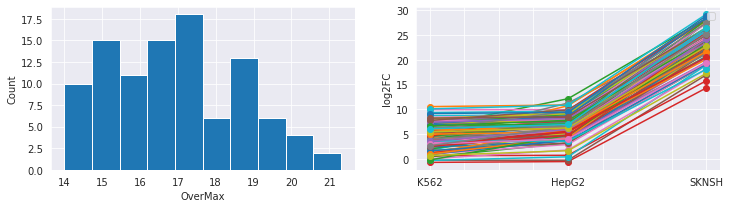


--------------- Running STREME ---------------

{'alength': 4, 'w': 10, 'nsites': 87, 'E': 0.0029}


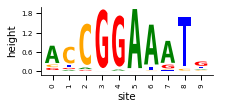

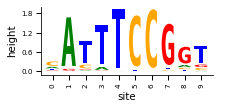

{'alength': 4, 'w': 9, 'nsites': 71, 'E': 0.0029}


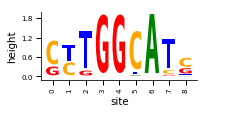

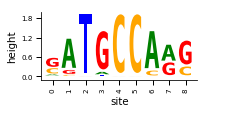

{'alength': 4, 'w': 12, 'nsites': 52, 'E': 0.13}


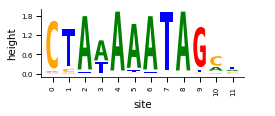

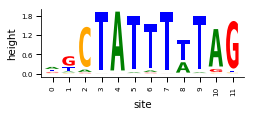

{'alength': 4, 'w': 11, 'nsites': 34, 'E': 0.23}


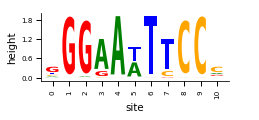

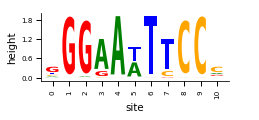

{'alength': 4, 'w': 11, 'nsites': 65, 'E': 0.35}


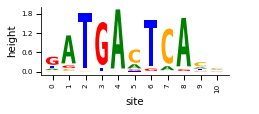

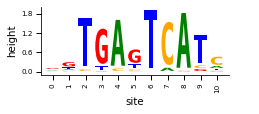

{'alength': 4, 'w': 8, 'nsites': 67, 'E': 1.4}


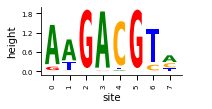

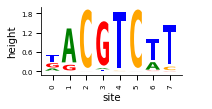

{'alength': 4, 'w': 12, 'nsites': 32, 'E': 4}


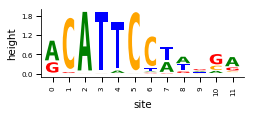

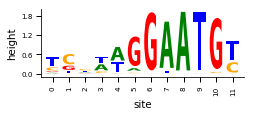

{'alength': 4, 'w': 11, 'nsites': 24, 'E': 6.1}


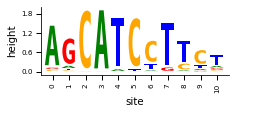

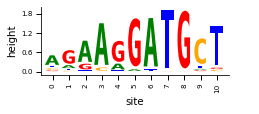


100 proposals generated in 0:21:32.407198


                         *********************************
                         * TOP MOTIF FROM EACH ITERATION *
                         *********************************



--------------- Top motif 0 | Sites: 87 | E-value: 0.0029 ---------------



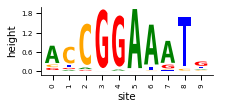

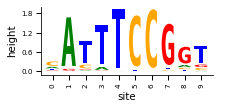

In [18]:
#-------------------- Choose settings --------------------
bias_cell = 2
score_pct = 0.0
num_proposed_sequences = [100] #[100, 100, 100, 100, 100, 100] 
over_max_threshold = 14
max_attempts = 200

save_results = True
in_line_plots = True

num_generations = 30
model_queries_per_batch = 800
eval_batch_size = 20           #20  100
sequences_batch_size = 20      #200 500
rho = 2                        #50  40
threshold = 0.25               #0.1 0.25
recomb_rate = 0.1              #0.1 0.5
mu = 1
a_min = -200.0
a_max = 600.0
    
cell_names = ['k562', 'hepg2', 'sknsh']
settings = {'bias_cell': cell_names[bias_cell],
            'num_proposed_sequences': num_proposed_sequences,
            'num_generations': num_generations,
            'score_pct': score_pct,
            'model': hpo_rec,
            'num_generations': num_generations,
            'model_queries_per_batch': model_queries_per_batch,
            'eval_batch_size': eval_batch_size,
            'sequences_batch_size': sequences_batch_size,
            'rho': rho,
            'threshold': threshold,
            'recomb_rate': recomb_rate,
            'mu': mu,
            'a_min': a_min,
            'a_max': a_max
           }

if save_results:
    log_path = create_new_log_folder_in('run_logs/')
    os.makedirs(log_path + '/figures')
    figures_path = log_path + '/figures/'
    with open(log_path + 'settings.txt', 'w') as ofile:
        for item in settings.items():
            ofile.write(f'{item[0]}: {item[1]}' + "\n")
    print(f'Files and logs will be saved in {log_path}')


#-------------------- Begin optimization --------------------

streme_results_list = []
ppms_list = []
top_ppms_summaries = []
all_proposals = []
all_predictions = []
all_overmaxs = []
for penalty_iteration, num_proposed_sequences in enumerate(num_proposed_sequences):    
    start_time = datetime.now()
    frame_print(f'Designing with {penalty_iteration} motif penalties')
    
    fitness_fn = OverMaxFitness_w_penalty(model=model,
                                          ppms=ppms_list,
                                          bias_cell=bias_cell,
                                          score_pct=score_pct,
                                          a_min=a_min,
                                          a_max=a_max)
    proposed_sequences = []
    proposed_sequences_overmaxs = []
    predictions = []
    attempts = 1
    while (len(proposed_sequences) < num_proposed_sequences) and (attempts <= max_attempts):
        description_str = f'Proposal {len(proposed_sequences)+1}/{num_proposed_sequences} (Attempt {attempts}/{max_attempts})'
        generator = AdaLead(model_queries_per_batch=model_queries_per_batch,
                            eval_batch_size=eval_batch_size,
                            sequences_batch_size=sequences_batch_size,
                            rho=rho,
                            threshold=threshold,
                            recomb_rate=recomb_rate, 
                            mu=mu,
                            fitness_fn=fitness_fn)
        generator.cuda()
        generator.run(num_iterations=num_generations, desc_str=description_str)
        top_sequence = generator.new_seqs[0]
        pred = fitness_fn.model(generator.pad(utils.dna2tensor(top_sequence).view(1,4,200).cuda())).detach().cpu()
        over_max = fitness_fn.over_max_diff(pred).item()
        if over_max >= over_max_threshold:
            proposed_sequences.append(top_sequence)
            proposed_sequences_overmaxs.append(over_max)
            predictions.append(pred)
            #print(f'Proposal accepted. Predictions {pred.detach().cpu().tolist()[0]}', flush=True)
        else:
            print(f'Proposal rejected. OverMax={over_max} < {over_max_threshold}', flush=True)
        attempts += 1
        
    predictions = torch.cat(predictions)
    all_proposals.append(proposed_sequences)
    all_overmaxs.append(proposed_sequences_overmaxs)
    all_predictions.append(predictions)

    if in_line_plots:
        prediction_df = pd.DataFrame(predictions.numpy(), columns=['K562', 'HepG2', "SKNSH"])
        with sns.axes_style("darkgrid"):
            fig = plt.figure(figsize=(12,3))
            ax1 = fig.add_subplot(121)
            plt.hist(proposed_sequences_overmaxs)
            plt.ylabel('Count')
            plt.xlabel('OverMax')

            ax2 = fig.add_subplot(122)
            prediction_df.T.plot(style='-o', ax=ax2)
            #plt.ylim(-3,8)
            plt.legend('')
            plt.ylabel('log2FC')

            plt.savefig(figures_path + f'round_{penalty_iteration}.png', bbox_inches='tight')
            plt.show()
        decor_print('Running STREME')
    else:
        print('Running STREME...')

    streme_results = streme(proposed_sequences)
    parsed_output = parse_streme_output(streme_results['output'])
    streme_results_list.append(parsed_output)
    ppms_list.append(torch.Tensor(parsed_output['motif_results'][0]['ppm']))  
    top_ppms_summaries.append(parsed_output['motif_results'][0]['summary'])

    if in_line_plots:
        show_streme_motifs(parsed_output)
    if save_results:
        user = 'rc'
        cell_name = cell_names[bias_cell]
        generator_name = 'al'
        track_name = 'track_' + os.path.basename(log_path.rstrip('/')).split('_')[1].zfill(3)
        round_name = 'round_' + str(penalty_iteration)
        time_stamp = time.strftime("%Y%m%d_%H%M%S")
        random_tag = str(random.randint(10000000,99999999))
        file_name =  user + '__' + \
                     cell_name + '__' + \
                     generator_name + '__' + \
                     track_name + '__' + \
                     round_name + '__' + \
                     time_stamp + '__' + \
                     random_tag + \
                     '.fa'
        with open(log_path + file_name, 'w') as ofile:
            for seq_idx, sequence_str in enumerate(proposed_sequences):
                seq_name = 'sequence_' + str(seq_idx)
                ofile.write(">" + seq_name + "\n" + sequence_str + "\n")
        with open(log_path + 'top_ppms.pkl', 'wb') as fp:
            pickle.dump(ppms_list, fp)
        with open(log_path + 'top_ppms_summaries.txt', 'w') as ofile:
            for summary in top_ppms_summaries:
                ofile.write(str(summary) + "\n")        

    end_time = datetime.now()
    print('', flush=True)
    print(f'{num_proposed_sequences} proposals generated in {end_time - start_time}', flush=True)
    
#------------------ Show top motifs ------------------  
frame_print('Top motif from each iteration')
for ppm_idx, ppm in enumerate(ppms_list):
    ppm = align_to_alphabet(ppm)
    icm = ppm_to_IC(ppm)
    icm_rc = reverse_complement(icm)
    nsites = top_ppms_summaries[ppm_idx]['nsites']
    evalue = top_ppms_summaries[ppm_idx]['E']
    decor_print(f'Top motif {ppm_idx} | Sites: {nsites} | E-value: {evalue}')
    matrix_to_dms(icm, y_max=2)
    plt.savefig(figures_path + f'top_motif_{ppm_idx}.png', bbox_inches='tight')
    plt.show()
    matrix_to_dms(icm_rc, y_max=2)
    plt.savefig(figures_path + f'top_motif_rc_{ppm_idx}.png', bbox_inches='tight')
    plt.show()
    
if not in_line_plots:
    penalty_idx = 0
    for predictions, proposed_sequences_overmaxs in zip(all_predictions, all_overmaxs): 
        prediction_df = pd.DataFrame(predictions.numpy(), columns=['K562', 'HepG2', "SKNSH"])
        with sns.axes_style("darkgrid"):
            fig = plt.figure(figsize=(12,3))
            ax1 = fig.add_subplot(121)
            plt.hist(proposed_sequences_overmaxs)
            plt.ylabel('Count')
            plt.xlabel('OverMax')

            ax2 = fig.add_subplot(122)
            prediction_df.T.plot(style='-o', ax=ax2)
            #plt.ylim(-3,8)
            plt.legend('')
            plt.ylabel('log2FC')

            plt.savefig(figures_path + f'round_{penalty_idx}.png', bbox_inches='tight')
            plt.show()
            penalty_idx += 1

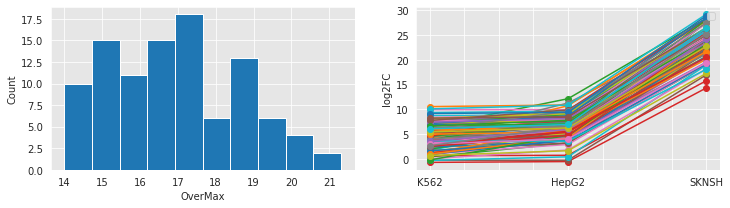

In [43]:
if True:
    penalty_idx = 0
    for predictions, proposed_sequences_overmaxs in zip(all_predictions, all_overmaxs): 
        prediction_df = pd.DataFrame(predictions.numpy(), columns=['K562', 'HepG2', "SKNSH"])
        with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
            fig = plt.figure(figsize=(12,3))
            ax1 = fig.add_subplot(121)
            plt.hist(proposed_sequences_overmaxs)
            plt.ylabel('Count')
            plt.xlabel('OverMax')

            ax2 = fig.add_subplot(122)
            prediction_df.T.plot(style='-o', ax=ax2)
            #plt.ylim(-3,8)
            plt.legend('')
            plt.ylabel('log2FC')

            plt.savefig(figures_path + f'round_{penalty_idx}.png', bbox_inches='tight')
            plt.show()
            penalty_idx += 1